<a href="https://colab.research.google.com/github/Falakejaz786/Image-Generation-for-E-commerce/blob/main/ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rembg Pillow ipywidgets webcolors
!pip install onnxruntime

In [2]:
import io
from rembg import remove
from PIL import Image
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import webcolors


In [3]:
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
color_input = widgets.Text(description='Color:', placeholder='e.g. red, blue, pink')
apply_button = widgets.Button(description="Apply Color")
output = widgets.Output()

original_img = None
foreground = None


In [4]:
def color_name_to_rgb(color_name):
    try:
        return webcolors.name_to_rgb(color_name.lower())
    except ValueError:
        return None


In [5]:
def recolor_product(foreground, target_rgb):
    fg = foreground.convert("RGBA")
    data = np.array(fg)
    alpha = data[..., 3]
    product_mask = alpha > 0
    r, g, b = data[..., 0].astype(np.float32), data[..., 1].astype(np.float32), data[..., 2].astype(np.float32)
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    norm_lum = luminance / 255.0
    new_r, new_g, new_b = np.zeros_like(r), np.zeros_like(g), np.zeros_like(b)
    new_r[product_mask] = target_rgb[0] * norm_lum[product_mask]
    new_g[product_mask] = target_rgb[1] * norm_lum[product_mask]
    new_b[product_mask] = target_rgb[2] * norm_lum[product_mask]
    new_r[~product_mask], new_g[~product_mask], new_b[~product_mask] = r[~product_mask], g[~product_mask], b[~product_mask]
    data[..., 0:3] = np.stack([new_r, new_g, new_b], axis=-1).astype(np.uint8)
    recolored = Image.fromarray(data, mode="RGBA")
    return recolored


In [6]:
def on_apply_color(b):
    with output:
        clear_output()
        color_name = color_input.value.strip()
        if not color_name:
            print("Please enter a color name (e.g. red, blue, pink).")
            return
        rgb = color_name_to_rgb(color_name)
        if rgb is None:
            print(f"Color '{color_name}' not recognized. Try a different color.")
            return
        recolored_fg = recolor_product(foreground, rgb)
        final = Image.alpha_composite(original_img.convert("RGBA"), recolored_fg)
        display(final)
        print(f"Showing product recolored to '{color_name}'. Enter another color to recolor again!")


In [7]:
def on_upload_change(change):
    global original_img, foreground
    if upload_widget.value:
        clear_output()
        filename = list(upload_widget.value.keys())[0]
        print(f"Uploaded: {filename}")

        file_bytes = upload_widget.value[filename]['content']
        original_img = Image.open(io.BytesIO(file_bytes)).convert("RGBA")
        display(original_img)
        print("Removing background to isolate product...")

        foreground = remove(original_img)
        print("Background removed. Now enter the color you want the product to be recolored to.")
        display(color_input, apply_button, output)


Uploaded: Pink_Birkin_bag.jpg


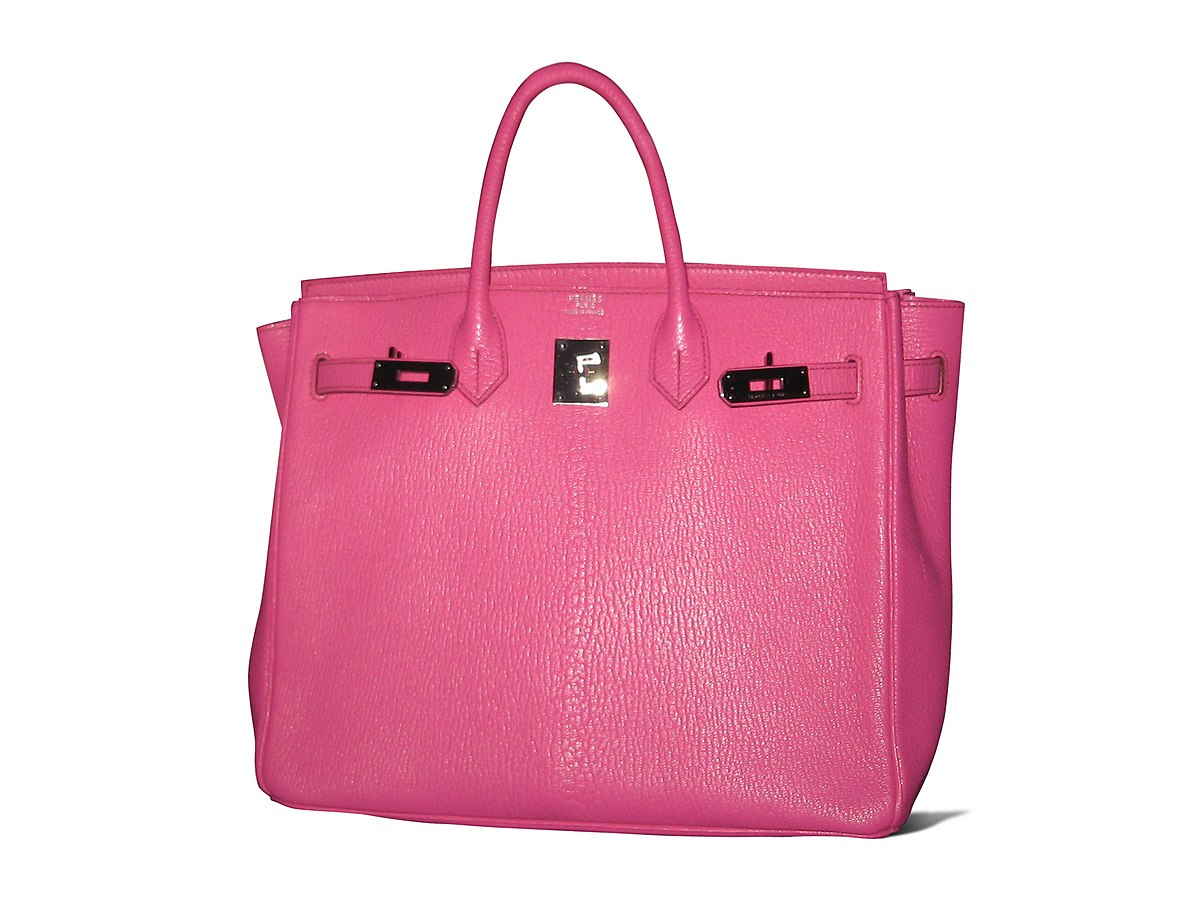

Removing background to isolate product...


100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 56.6GB/s]


Background removed. Now enter the color you want the product to be recolored to.


Text(value='', description='Color:', placeholder='e.g. red, blue, pink')

Button(description='Apply Color', style=ButtonStyle())

Output()

In [8]:
apply_button.on_click(on_apply_color)
upload_widget.observe(on_upload_change, names='value')

print("Upload your product image below:")
display(upload_widget)


In [9]:
!pip install rembg Pillow mediapipe

import io
from rembg import remove
from PIL import Image
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import mediapipe as mp

In [10]:
selfie_upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Selfie')
product_upload = widgets.FileUpload(accept='image/*', multiple=False, description='Upload Product')
product_desc = widgets.Text(description='Product:', placeholder='e.g. red sunglasses')
tryon_button = widgets.Button(description="Try On")
output = widgets.Output()

user_selfie = None
product_img = None
product_img_no_bg = None

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

def on_selfie_upload(change):
    global user_selfie
    if selfie_upload.value:
        fname = list(selfie_upload.value.keys())[0]
        content = selfie_upload.value[fname]['content']
        user_selfie = Image.open(io.BytesIO(content)).convert("RGBA")
        with output:
            clear_output()
            print(f"Selfie '{fname}' uploaded.")
            display(user_selfie)
            display(product_upload, product_desc, tryon_button)

def on_product_upload(change):
    global product_img
    if product_upload.value:
        fname = list(product_upload.value.keys())[0]
        content = product_upload.value[fname]['content']
        product_img = Image.open(io.BytesIO(content)).convert("RGBA")
        with output:
            clear_output()
            print(f"Product '{fname}' uploaded.")
            display(product_img)
            display(product_desc, tryon_button)

def remove_background(img):
    img_bytes = io.BytesIO()
    img.save(img_bytes, format='PNG')
    img_no_bg_bytes = remove(img_bytes.getvalue())
    img_no_bg = Image.open(io.BytesIO(img_no_bg_bytes)).convert("RGBA")
    return img_no_bg

def on_tryon(b):
    global product_img_no_bg
    with output:
        clear_output()
        if user_selfie is None:
            print("Upload a selfie first!")
            return
        if product_img is None:
            print("Upload a product image first!")
            return
        print("Removing product background...")
        product_img_no_bg = remove_background(product_img)
        display(product_img_no_bg)
        print("Detecting face landmarks...")
        selfie_np = np.array(user_selfie.convert('RGB'))
        results = face_mesh.process(selfie_np)
        if not results.multi_face_landmarks:
            print("No face detected in selfie.")
            display(user_selfie)
            return
        landmarks = results.multi_face_landmarks[0].landmark
        h, w, _ = selfie_np.shape
        left_eye = landmarks[33]
        right_eye = landmarks[263]
        left_eye_x, left_eye_y = int(left_eye.x * w), int(left_eye.y * h)
        right_eye_x, right_eye_y = int(right_eye.x * w), int(right_eye.y * h)
        glasses_width = right_eye_x - left_eye_x
        scale_factor = 2.0
        new_width = int(glasses_width * scale_factor)
        aspect_ratio = product_img_no_bg.height / product_img_no_bg.width
        new_height = int(new_width * aspect_ratio)
        product_resized = product_img_no_bg.resize((new_width, new_height), Image.LANCZOS)
        center_x = (left_eye_x + right_eye_x) // 2
        center_y = (left_eye_y + right_eye_y) // 2 - new_height // 40
        paste_position = (center_x - new_width // 2, center_y - new_height // 2)
        selfie_copy = user_selfie.copy()
        selfie_copy.paste(product_resized, paste_position, product_resized)
        print("Here is your virtual try-on result:")
        display(selfie_copy)

selfie_upload.observe(on_selfie_upload, names='value')
product_upload.observe(on_product_upload, names='value')
tryon_button.on_click(on_tryon)

display(selfie_upload, output)


FileUpload(value={}, accept='image/*', description='Upload Selfie')

Output()

In [11]:
!pip install fastapi uvicorn pillow rembg mediapipe numpy webcolors
